In [96]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

palette = sb.color_palette()

# import bayesian estimation package
import ndim_homogeneous_distinguishability as hd

In [97]:
def plot_2D_ex_traj(D, c):
    df = hd.simulate_diffusion_df(n_dim = 2, d_const = D, n_steps = 100, dt = 1, loc_std = 0.03)
    if c==1:
        c1 = palette[0]
        c2 = palette[9]
    else:
        c1 = palette[8]
        c2 = palette[1]
    plt.plot([x[0] for x in df['x']], [x[1] for x in df['x']], label='true', color=c1)
    plt.plot([x[0] for x in df['x']], [x[1] for x in df['x_obs']], label='observed', color=c2);
    plt.xlabel(r'x ($\mu$m)')
    plt.ylabel(r'y ($\mu$m)')
    plt.legend();
    return df

In [145]:
def draw_all_posteriors(df1, df2, D1, D2):
    
    posterior1t,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr'])
    posterior1o,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr_obs'])
    posterior2t,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df2['dr'])
    posterior2o,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df2['dr_obs'])
    
    xx = np.linspace(D1-6*posterior1o.std(),D2+6*posterior2o.std(), 50)
    
    plt.plot(xx, posterior1t.pdf(xx), color = palette[0], label = 'D1 True')
    plt.plot(xx, posterior1o.pdf(xx), color = palette[9], label='D1 Observed')
    plt.plot(xx, posterior2t.pdf(xx), color = palette[8], label='D2 True')
    plt.plot(xx, posterior2o.pdf(xx), color = palette[1], label='D2 Observed')
    plt.axvline(x=D1, linestyle=':', color=palette[7])
    plt.axvline(x=D2, linestyle=':', color=palette[7])
    plt.legend()
    plt.xlabel('Diffusion Constant')
    plt.ylabel('Probability density');

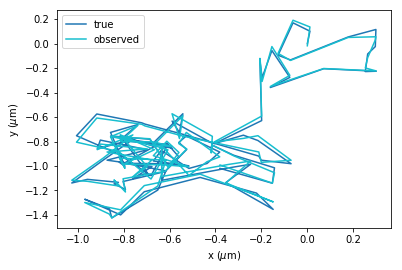

In [146]:
D1 = 0.01
df1 = plot_2D_ex_traj(D1, 1)

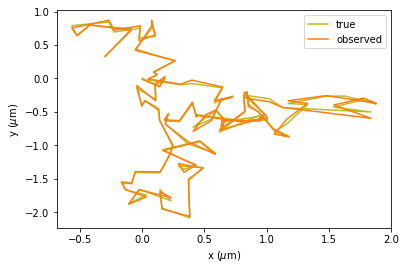

In [147]:
D2 = 1.5*D1
df2 = plot_2D_ex_traj(D2, 2)

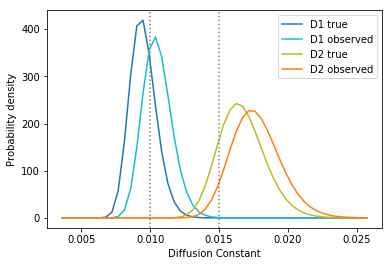

In [142]:
draw_all_posteriors(df1, df2, D1, D2)

From this figure we can branch to either error analysis (distiburion max vs true value) for true and observed (localization error effects) or branch to posterior comparisons via the KL divergence. Example figures for each of these are contained in the tutorial notebook. I'm leaning towards that order.